# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).






In [ ]:
import pandas as pd

In [ ]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

In [ ]:
# Example of using KElbowVisualizer

# from yellowbrick.cluster import KElbowVisualizer
# visualizer = KElbowVisualizer(clustering_model, k=(2, 10), metric='distortion', timings=False)
# visualizer.fit(preprocessed_data)
# visualizer.show()
# optimal_k = visualizer.elbow_value_


# Example of using PCA

# from sklearn.decomposition import PCA
# clusters = clustering_model.fit_predict(preprocessed_data)
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(preprocessed_data)
# pca1 = pca_result[:, 0]
# pca2 = pca_result[:, 1]
# # Visualizing Clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=pca1, y=pca2, hue=clusters, palette='tab10', data=data, alpha=0.7)
# plt.title(f'PCA Projection of Clusters (K={num_clusters})')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.show()

## 1. Import data

In [1]:
import pandas as pd

train_df = pd.read_csv("preprocessed_train_task1.csv")
test_df  = pd.read_csv("preprocessed_test_task1.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())

Train shape: (26029, 111)
Test shape : (6508, 111)


,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__capital_total,num__experience_estimate,num__has_capital,cat__workclass_?,cat__workclass_Federal-gov,...,cat__native-country_Puerto-Rico,cat__native-country_Scotland,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia,hours-per-week
0,-0.188070,-0.627661,-0.458342,0.0,0.0,0.0,-0.189256,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,38.0
1,0.992956,-0.768050,-0.458342,0.0,0.0,0.0,0.993455,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.0
2,-0.335699,0.237442,-0.051335,0.0,0.0,0.0,-0.337095,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.0
3,1.140584,-0.041966,-0.458342,0.0,0.0,0.0,1.141294,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.0
4,-0.630955,-1.093903,-0.458342,0.0,0.0,0.0,-0.632772,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.5


## 2. Pregătirea caracteristicilor (Feature Engineering)

Pentru realizarea analizei de tip clustering, variabila țintă (`hours-per-week`) este eliminată din setul de date, deoarece metodele de învățare nesupervizată nu utilizează etichete.

In [ ]:
# Separate features and target
target_col = "hours-per-week"

y_train = train_df[target_col]

# Features used for clustering (no target)
X_train = train_df.drop(columns=[target_col])

print("Clustering features shape:", X_train.shape)

Clustering features shape: (26029, 110)


In [ ]:
# Check for missing values
print("Missing values:", X_train.isnull().sum().sum())

display(X_train.describe().T.head())


Missing values: 0


,count,mean,std,min,25%,50%,75%,max
num__age,26029.0,-1.430421e-16,1.000019,-1.590539,-0.778583,-0.114256,0.697700,2.912124
num__fnlwgt,26029.0,1.086465e-16,1.000019,-1.840479,-0.728126,-0.090705,0.532031,2.403847
num__education-num,26029.0,-2.243905e-16,1.000019,-2.289875,-0.458342,-0.051335,0.762679,2.390708
num__capital-gain,26029.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
num__capital-loss,26029.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3. K-Means Clustering

Algoritmul K-Means este utilizat pentru a grupa observațiile în clustere omogene, pe baza distanței dintre ele.
Având în vedere natura datelor (numerice și standardizate), K-Means reprezintă o alegere adecvată.

Pentru determinarea numărului optim de clustere (K), este utilizată metoda „Elbow”, implementată cu ajutorul bibliotecii Yellowbrick.

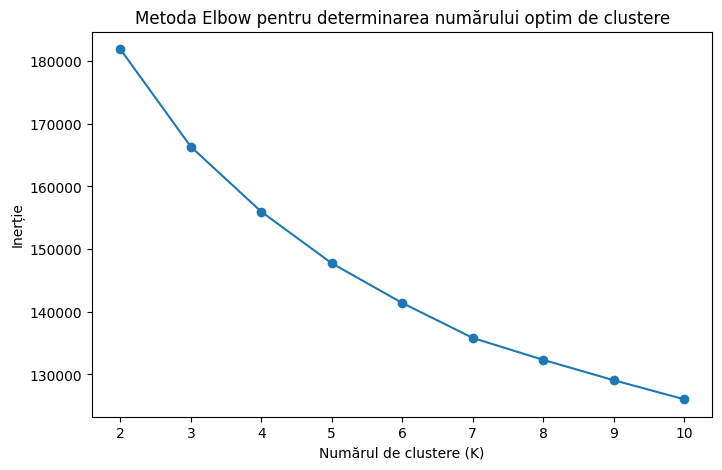

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_values = range(2, 11)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Numărul de clustere (K)")
plt.ylabel("Inerție")
plt.title("Metoda Elbow pentru determinarea numărului optim de clustere")
plt.show()


Pe baza graficului metodei Elbow, se observă o scădere accentuată a inerției până în jurul valorii K = 5,
după care rata de îmbunătățire devine marginală. Astfel, a fost ales K = 5 ca număr optim de clustere.

In [ ]:
# Antrenarea finală a modelului K-Means
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_kmeans = kmeans_final.fit_predict(X_train)

train_clustered = train_df.copy()
train_clustered["cluster_kmeans"] = clusters_kmeans

train_clustered[["cluster_kmeans"]].value_counts().sort_index()

cluster_kmeans
0                 4702
1                 6266
2                 3644
3                 6132
4                 5285
Name: count, dtype: int64

Distribuția observațiilor în cele 5 clustere este relativ echilibrată, fără apariția unor clustere extrem de mici sau dominante.
Acest lucru sugerează că algoritmul K-Means a identificat grupuri coerente în date.

In [12]:
from sklearn.metrics import silhouette_score

silhouette_kmeans = silhouette_score(X_train, clusters_kmeans)
print("Silhouette Score (K-Means, K=5):", silhouette_kmeans)


Silhouette Score (K-Means, K=5): 0.10970811044176981


Scorul Silhouette obținut pentru K-Means (K = 5) este de aproximativ 0.11, indicând un nivel moderat de separare între clustere.
Această valoare este considerată acceptabilă în contextul unui set de date socio-economic complex, cu dimensionalitate ridicată
și variabile eterogene, unde suprapunerea parțială între grupuri este de așteptat.

## 4. Vizualizarea clusterelor folosind PCA

Pentru a vizualiza structura clusterelor într-un spațiu bidimensional,
a fost aplicată Analiza Componentelor Principale (PCA), care reduce dimensionalitatea datelor
păstrând cât mai mult din variația inițială.

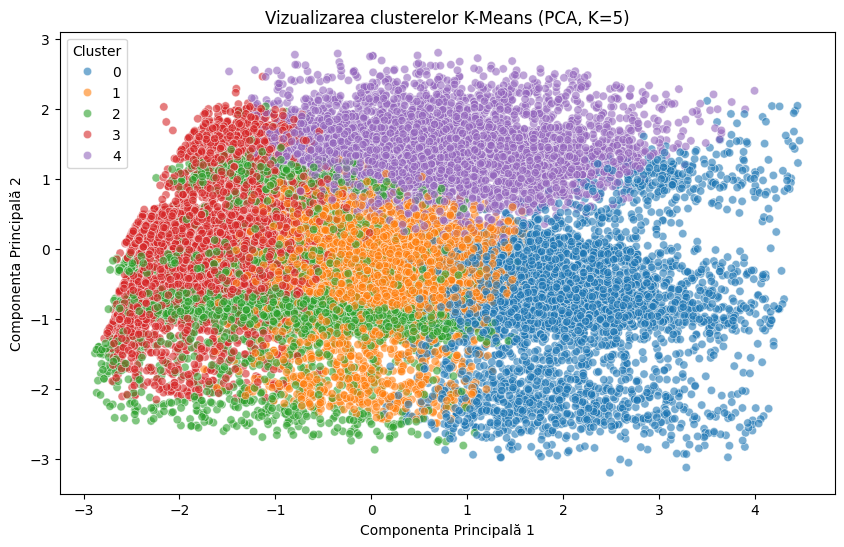

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducere dimensionalitate la 2 componente
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)

# DataFrame pentru plot
pca_df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters_kmeans
})

# Plot clustere
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="tab10",
    alpha=0.6
)
plt.title("Vizualizarea clusterelor K-Means (PCA, K=5)")
plt.xlabel("Componenta Principală 1")
plt.ylabel("Componenta Principală 2")
plt.legend(title="Cluster")
plt.show()


Vizualizarea clusterelor utilizând PCA indică o separare parțială între grupuri,
în special de-a lungul primei componente principale.
Se observă o suprapunere între clustere, în special pe a doua componentă principală,
ceea ce este de așteptat în cazul unui set de date socio-economic complex.

Această structură confirmă rezultatele obținute prin scorul Silhouette,
care indică o separare moderată între clustere, dar și existența unor tipare coerente în date.

## 5. Analiza și interpretarea clusterelor

In [18]:
cols = train_clustered.columns

print("Coloane care conțin 'age':", [c for c in cols if "age" in c])
print("Coloane care conțin 'education':", [c for c in cols if "education" in c])
print("Coloane care conțin 'experience':", [c for c in cols if "experience" in c])
print("Coloane care conțin 'capital':", [c for c in cols if "capital" in c])

Coloane care conțin 'age': ['num__age', 'cat__occupation_Exec-managerial']
Coloane care conțin 'education': ['num__education-num', 'cat__education_10th', 'cat__education_11th', 'cat__education_12th', 'cat__education_1st-4th', 'cat__education_5th-6th', 'cat__education_7th-8th', 'cat__education_9th', 'cat__education_Assoc-acdm', 'cat__education_Assoc-voc', 'cat__education_Bachelors', 'cat__education_Doctorate', 'cat__education_HS-grad', 'cat__education_Masters', 'cat__education_Preschool', 'cat__education_Prof-school', 'cat__education_Some-college']
Coloane care conțin 'experience': ['num__experience_estimate']
Coloane care conțin 'capital': ['num__capital-gain', 'num__capital-loss', 'num__capital_total', 'num__has_capital']


In [ ]:
# Media variabilelor numerice pentru fiecare cluster
cluster_summary = train_clustered.groupby("cluster_kmeans").mean(numeric_only=True)

important_features = [
    "num__age",
    "num__education-num",
    "num__experience_estimate",
    "num__capital_total",
    "hours-per-week"
]

display(cluster_summary[important_features])


,num__age,num__education-num,num__experience_estimate,num__capital_total,hours-per-week
cluster_kmeans,,,,,
0,1.484600,-0.524821,1.485801,0.0,40.246066
1,-0.053011,-0.446780,-0.054004,0.0,42.386530
2,-0.505204,-0.262546,-0.506071,0.0,40.952936
3,-1.055916,-0.156804,-1.054904,0.0,38.619374
4,0.315500,1.359597,0.315033,0.0,43.712867


In [ ]:
# Variabilele care variază cel mai mult între clustere (după medii)
between_cluster_var = cluster_summary.var().sort_values(ascending=False)
display(between_cluster_var.head(15))


hours-per-week                            3.837916
num__experience_estimate                  0.917947
num__age                                  0.917415
num__fnlwgt                               0.723384
num__education-num                        0.604219
cat__marital-status_Never-married         0.122421
cat__marital-status_Married-civ-spouse    0.076317
cat__relationship_Husband                 0.067284
cat__education_Bachelors                  0.047536
cat__relationship_Own-child               0.042728
cat__education_HS-grad                    0.038995
cat__occupation_Prof-specialty            0.023235
cat__education_Some-college               0.016758
cat__sex_Male                             0.013443
cat__sex_Female                           0.013443
dtype: float64

Analiza mediilor variabilelor numerice pentru fiecare cluster evidențiază diferențe clare între grupuri.
În special, variabilele precum numărul de ore lucrate pe săptămână, experiența profesională estimată
și vârsta prezintă cea mai mare variație între clustere, sugerând că acestea joacă un rol central
în segmentarea indivizilor.

Aceste rezultate indică existența unor profiluri socio-economice distincte,
diferențiate prin niveluri diferite de experiență, educație și implicare pe piața muncii.

## 6. Hierarchical Clustering

### Dendrogramă (subset de date)

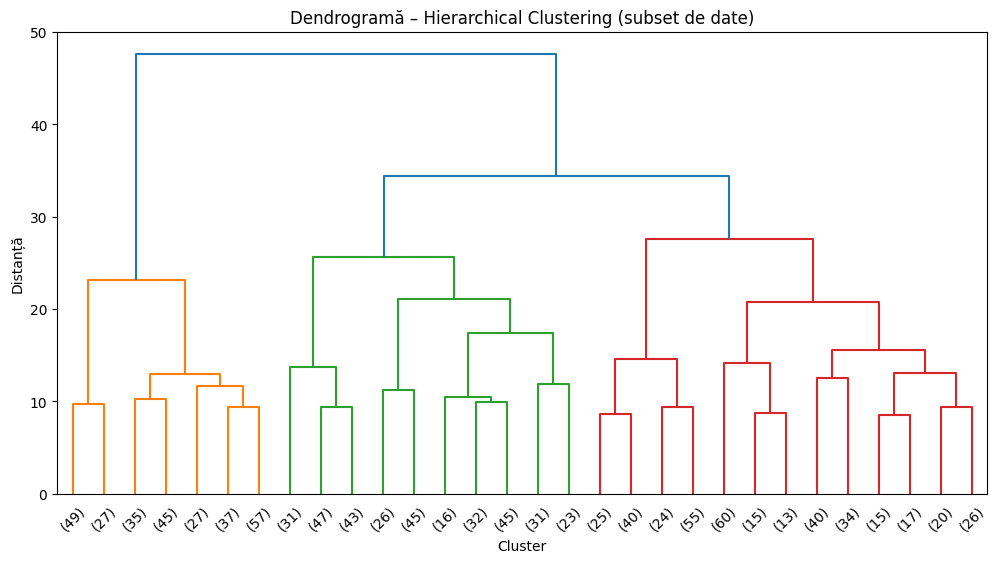

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Subset pentru dendrogramă (ex: 1000 observații)
np.random.seed(42)
sample_idx = np.random.choice(X_train.shape[0], size=1000, replace=False)
X_sample = X_train.iloc[sample_idx]

# Linkage matrix (Ward = bun pentru date numerice)
Z = linkage(X_sample, method="ward")

# Plot dendrogramă
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="lastp", p=30)
plt.title("Dendrogramă – Hierarchical Clustering (subset de date)")
plt.xlabel("Cluster")
plt.ylabel("Distanță")
plt.show()


Dendrograma sugerează existența a aproximativ 4–6 clustere,
în concordanță cu rezultatele obținute anterior prin metoda K-Means (K = 5).
Această consistență indică stabilitatea structurii identificate în date.

### Agglomerative Clustering

In [20]:
from sklearn.cluster import AgglomerativeClustering

# Model hierarchical clustering
agglo = AgglomerativeClustering(n_clusters=5, linkage="ward")
clusters_hier = agglo.fit_predict(X_train)

# Adăugăm etichetele în dataset
train_clustered["cluster_hierarchical"] = clusters_hier

train_clustered["cluster_hierarchical"].value_counts().sort_index()


cluster_hierarchical
0    5402
1    5115
2    5704
3    6186
4    3622
Name: count, dtype: int64

Rezultatele clusteringului ierarhic prezintă o distribuție comparabilă a observațiilor
față de metoda K-Means, sugerând că structura datelor este relativ robustă
indiferent de algoritmul de clustering utilizat.

### Vizualizarea clusteringului ierarhic în 2D (PCA)

Pentru a compara vizual rezultatele clusteringului ierarhic cu cele obținute prin K-Means,
proiectăm observațiile în 2D folosind PCA și colorăm punctele în funcție de clusterul atribuit.


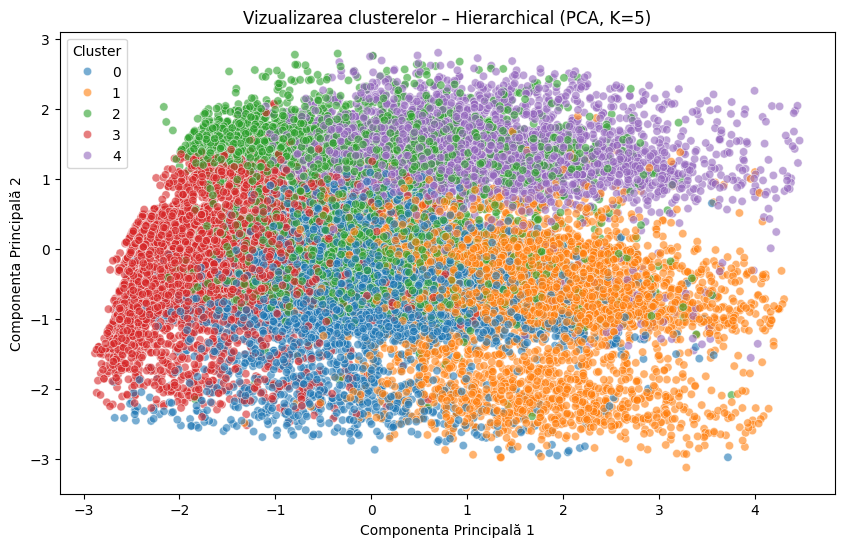

In [22]:
import seaborn as sns

# Refolosim X_pca calculat anterior (din PCA pentru K-Means).
# Dacă nu mai există în notebook, rulează din nou celula PCA:
# X_pca = PCA(n_components=2, random_state=42).fit_transform(X_train)

pca_hier_df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters_hier
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_hier_df,
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="tab10",
    alpha=0.6
)
plt.title("Vizualizarea clusterelor – Hierarchical (PCA, K=5)")
plt.xlabel("Componenta Principală 1")
plt.ylabel("Componenta Principală 2")
plt.legend(title="Cluster")
plt.show()


## 7. DBSCAN

In [21]:
from sklearn.cluster import DBSCAN

# Model DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_train)

# Adăugăm etichetele
train_clustered["cluster_dbscan"] = clusters_dbscan

train_clustered["cluster_dbscan"].value_counts().sort_index()


cluster_dbscan
-1     6220
 0    18948
 1      434
 2       58
 3       73
 4      174
 5       53
 6       35
 7       21
 8       13
Name: count, dtype: int64

Rezultatele DBSCAN indică identificarea unui număr limitat de clustere dense,
precum și a unui număr semnificativ de observații etichetate ca zgomot.
Acest comportament sugerează că datele analizate nu prezintă regiuni de densitate clar delimitate,
ceea ce este frecvent întâlnit în seturi de date socio-economice de dimensionalitate ridicată.

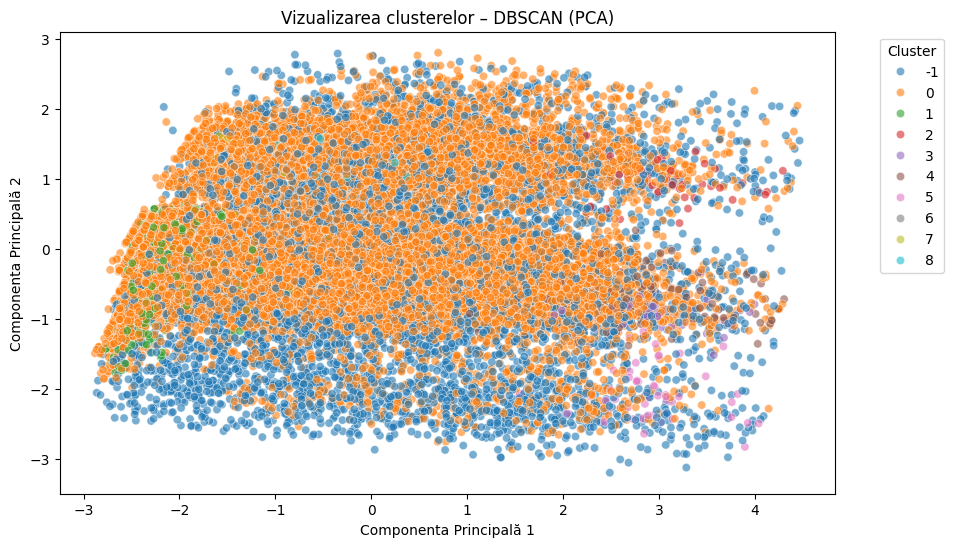

In [24]:
pca_db_df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters_dbscan
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_db_df,
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="tab10",
    alpha=0.6
)
plt.title("Vizualizarea clusterelor – DBSCAN (PCA)")
plt.xlabel("Componenta Principală 1")
plt.ylabel("Componenta Principală 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [25]:
# Distribuția clusterelor (proporții)
dist_dbscan = pd.Series(clusters_dbscan).value_counts(normalize=True).sort_index()
print(dist_dbscan)

-1    0.238964
 0    0.727957
 1    0.016674
 2    0.002228
 3    0.002805
 4    0.006685
 5    0.002036
 6    0.001345
 7    0.000807
 8    0.000499
Name: proportion, dtype: float64


### Evaluarea DBSCAN (Silhouette Score pe observațiile non-noise)

In [26]:
mask_core = clusters_dbscan != -1
labels_core = clusters_dbscan[mask_core]

n_clusters_core = len(set(labels_core))
n_points_core = mask_core.sum()

print("Puncte non-noise:", n_points_core)
print("Nr. clustere (fără noise):", n_clusters_core)

if n_clusters_core >= 2:
    sil_dbscan = silhouette_score(X_train[mask_core], labels_core)
    print("Silhouette Score (DBSCAN, fără noise):", sil_dbscan)
else:
    print("Silhouette Score nu poate fi calculat (mai puțin de 2 clustere fără noise).")

Puncte non-noise: 19809
Nr. clustere (fără noise): 9
Silhouette Score (DBSCAN, fără noise): -0.10155267565767458


## 8. Concluzii

K-Means a oferit cea mai interpretabilă soluție, cu un număr optim de clustere (K = 5),
susținut atât de metoda Elbow, cât și de analiza PCA. Clusteringul ierarhic a confirmat
structura identificată de K-Means, sugerând stabilitatea tiparelor descoperite în date.
În schimb, DBSCAN s-a dovedit mai puțin potrivit pentru acest set de date, din cauza
dimensionalității ridicate și a absenței unor regiuni de densitate clar delimitate.

Per ansamblu, rezultatele indică existența unor tipare socio-economice coerente,
diferențiate în principal prin vârstă, experiență profesională și numărul de ore lucrate pe săptămână.